# Proteomic Data Aggregation and Visualization


This notebook demonstrates aggregation of proteomic data via the National Microbiome Data Collaborative (NMDC)'s [Runtime API](https://api.microbiomedata.org/docs). It highlights how the NMDC's schema can be used to overcome some of the numerous challenges associated with this type of aggregation. Please note that this notebook is intended for individuals with experience performing mass spectrometry based proteomic analyses and that various parameter and processing choices were made for this example use case. They are not broadly applicable and should be adjusted as needed. 


Notebook Steps:

1) Assess background information and collect datasets for an example study of riverbed sediment along the Columbia River

2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

3) Collapse to unique peptides and normalize quantification

4) Extract functional gene annotations for proteins

5) Generate annotation and protein mappings for peptides using "razor protein" parsimony strategy

6) Perform protein rollup using the "razor protein" results and summarize into an aggregated table of relative protein abundance

Import libraries and R scripts containing functions necessary to run this notebook. `aggregation_functions.R` (also in this folder) includes spectral probability filtering and protein mapping functions. `utility_functions.R` (located in the base directory) includes functions for API traversal of the collections endpoint.

In [1]:
# Setup 
# Add renv project library to R environment variable libPaths()
.libPaths(c(.libPaths(), "../../renv/library/*/R-*/*"))

# Load required packages
suppressPackageStartupMessages({
  library(dplyr, warn.conflicts = FALSE)
  library(tidyr, warn.conflicts = FALSE)
  library(stringr, warn.conflicts = FALSE)
  library(readr, warn.conflicts = FALSE)
  library(ggplot2, warn.conflicts = FALSE)
  library(jsonlite, warn.conflicts = FALSE)
  library(grid, warn.conflicts = FALSE)
  })

# Load NMDC API and protein aggregation functions from this repo
if(Sys.getenv("COLAB_BACKEND_VERSION") == "") {
  source("../../utility_functions.R")
  source("aggregation_functions.R")
}

if(Sys.getenv("COLAB_BACKEND_VERSION") != "") {
  source("http://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/utility_functions.R")
  source("http://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/proteomic_aggregation/R/aggregation_functions.R")
}

## 1) Assess background information and collect data for an example study of riverbed sediment along the Columbia River

Review the example study on the [NMDC data portal](https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51). Use the study `id` embedded in the url (`nmdc:sty-11-aygzgv51`) to collect all related data objects via the [NMDC Runtime API](https://api.microbiomedata.org/docs) and reformat the JSON output into a Pandas dataframe. These data objects reference both input files (i.e. raw instrument data, GFF) and output files (i.e. metaproteomic results) for the NMDC workflows.

In [2]:
data_objects <- get_data_objects_for_study("nmdc:sty-11-aygzgv51") %>%
  # Remove unnecessary columns for simpler dataframe
  select(id, name, data_object_type, url, biosample_id, in_manifest) %>%
  # Flatten in_manifest
  mutate(in_manifest = as.character(in_manifest))

Subset the data objects to 'Unfiltered Metaproteomic Results'. These files contain the proteomic workflow outputs that will be used for proteomic aggregation.

In [3]:
proteomic_output_df <- data_objects %>%
  filter(data_object_type == "Unfiltered Metaproteomics Results") %>%
  dplyr::rename(processed_dobj_id = "id") %>%
  arrange(biosample_id)

head(proteomic_output_df)

processed_dobj_id,name,data_object_type,url,biosample_id,in_manifest
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:dobj-11-pxnhdj84,nmdc_dobj-11-4kwfhk83_nmdc_dobj-11-haabxj14_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-4kwfhk83_nmdc_dobj-11-haabxj14_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-0jw5n594,nmdc:manif-11-7796sg87
nmdc:dobj-11-7wk9es16,nmdc_dobj-11-4kwfhk83_kaiko_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-4kwfhk83_kaiko_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-0jw5n594,NULL
nmdc:dobj-11-ct23bs36,nmdc_dobj-11-4kwfhk83_nmdc_dobj-11-haabxj14_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/2/nmdc_dobj-11-4kwfhk83_nmdc_dobj-11-haabxj14_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-0jw5n594,NULL
nmdc:dobj-11-1rynqk87,nmdc_dobj-11-k9e5nm54_kaiko_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-k9e5nm54_kaiko_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-13145k83,NULL
nmdc:dobj-11-mg2dnn24,nmdc_dobj-11-k9e5nm54_nmdc_dobj-11-tt8ykk73_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/2/nmdc_dobj-11-k9e5nm54_nmdc_dobj-11-tt8ykk73_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-13145k83,NULL
nmdc:dobj-11-xm1yjv87,nmdc_dobj-11-k9e5nm54_nmdc_dobj-11-tt8ykk73_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-k9e5nm54_nmdc_dobj-11-tt8ykk73_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-13145k83,nmdc:manif-11-7796sg87


There may be more than one processed data result for each biosample if it was processed multiple times using different workflow versions. Choose results from only one version of the workflow to use for this notebook.

In [4]:
# Retrieve workflow records that created the processed data results
version_output <- get_results_by_id(
    collection = "workflow_execution_set", 
    match_id_field = "has_output", 
    id_list = proteomic_output_df$processed_dobj_id, 
    fields = "id,has_output,version,has_input") 

proteomic_output_df <- version_output %>%

    # We will use has_input later on to search for Functional Annotation files
    select(-has_input) %>%

    # Clean up response
    unnest(has_output) %>%
    dplyr::rename(workflow_id = "id",
                  processed_dobj_id = "has_output") %>%

    # Join workflow information
    right_join(proteomic_output_df, by = join_by(processed_dobj_id)) %>%

    # Filter to only use v.1.2.1
    filter(version == "v1.2.1") %>%

    # Remove extra columns
    dplyr::select(-c(workflow_id, version))

head(proteomic_output_df)

processed_dobj_id,name,data_object_type,url,biosample_id,in_manifest
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:dobj-11-2k6s1505,nmdc_dobj-11-ms76kj12_nmdc_dobj-11-c5av0320_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-ms76kj12_nmdc_dobj-11-c5av0320_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-8e1rjf10,nmdc:manif-11-7796sg87
nmdc:dobj-11-3ak2bc31,nmdc_dobj-11-steksn39_nmdc_dobj-11-d3ahex66_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-steksn39_nmdc_dobj-11-d3ahex66_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-7qxjvr77,nmdc:manif-11-7796sg87
nmdc:dobj-11-4bwzhs42,nmdc_dobj-11-vs45wb84_nmdc_dobj-11-r3650k33_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-vs45wb84_nmdc_dobj-11-r3650k33_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-an5fyr03,nmdc:manif-11-7796sg87
nmdc:dobj-11-7psagy79,nmdc_dobj-11-erc74h90_nmdc_dobj-11-sekqwq68_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-erc74h90_nmdc_dobj-11-sekqwq68_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-3pvn5d70,nmdc:manif-11-7796sg87
nmdc:dobj-11-7x21d450,nmdc_dobj-11-wtsjqv17_nmdc_dobj-11-2hb27y88_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-wtsjqv17_nmdc_dobj-11-2hb27y88_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-937ebx72,nmdc:manif-11-7796sg87
nmdc:dobj-11-bxyvx506,nmdc_dobj-11-xvmb4058_nmdc_dobj-11-bvya7a43_msgfplus_syn_PlusSICStats.txt,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-xvmb4058_nmdc_dobj-11-bvya7a43_msgfplus_syn_PlusSICStats.txt,nmdc:bsm-13-1p0tct86,nmdc:manif-11-7796sg87


There are various requirements that enable mass spectrometry runs to be aggregated and analyzed together. For example, runs need to be performed in succession, on the same instrument. The NMDC schema can make it easier to find these proteomic results by linking them via a slot called `in_manifest`.

Look at the `in_manifest` id on these proteomic outputs to confirm that all runs are in the same manifest record, and pull that record. If that manifest record's `manifest_category` value is 'instrument_run', then it confirms that these are LC-MS/MS runs that were performed in succession on the same instrument. Proteomic outputs from different manifest records should not be aggregated.

In [5]:
# Display manifest IDs for the records in proteomic_output_df
manifest_id <- unique(proteomic_output_df$in_manifest)
manifest_id

[1] "nmdc:manif-11-7796sg87"

In [6]:
# In this case there is only one, print manifest information
manifest <- get_results_by_id(collection = "manifest_set", 
                              match_id_field = "id", 
                              id_list = manifest_id, 
                              fields = "")
manifest

id,manifest_category,type,description
<chr>,<chr>,<chr>,<chr>
nmdc:manif-11-7796sg87,instrument_run,nmdc:Manifest,collection of metaproteomic analyses from the same instrument run nmdc:sty-11-aygzgv51


Look at an example of the information in 'Unfiltered Metaproteomics Results', which contains peptide identification and relative abundance information.

In [7]:
paste("Reading file from", proteomic_output_df$url[1])

head(read_tsv(proteomic_output_df$url[1], show_col_types = FALSE, progress = FALSE))

[1] "Reading file from https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-ms76kj12_nmdc_dobj-11-c5av0320_msgfplus_syn_PlusSICStats.txt"

ResultID,Scan,FragMethod,SpecIndex,Charge,PrecursorMZ,DelM,DelM_PPM,MH,Peptide,...,PeakMaxIntensity,PeakSignalToNoiseRatio,FWHMInScans,PeakArea,ParentIonIntensity,ParentIonMZ,StatMomentsArea,PeakScanStart,PeakScanEnd,PeakWidthMinutes
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,36947,HCD,1,3,968.4745,-0.00469,-1.61740,2902.410,K.NYSPYYNTIDDLKDQIVDLTVGNNK.T,...,6619700,106.000,62,503970000,4468100,968.47,453600000,36866,37232,0
2,30576,HCD,2,3,1017.1652,-0.01640,-5.38151,3048.494,K.VLYDAEISQIHQSVTDTNVILSMDNSR.N,...,2595300,343.300,115,227780000,2481100,1017.17,206570000,30497,30787,0
3,21671,HCD,3,3,1050.4807,0.02323,7.38083,3148.401,K.NADSTLHTVTSGTAEGGESGTVFDSSYMAAGK.T,...,2393100,165.900,14,51712000,1454200,1050.48,53478000,21598,21730,0
4,30168,HCD,4,2,1097.4955,-0.01073,-4.89393,2193.994,K.SAYPGQITSNMFCAGYLEGGK.D,...,10190000,203.600,146,1796600000,1814600,1097.50,1745300000,29842,30311,0
5,29918,HCD,5,2,1098.0001,-0.00482,-2.19575,2193.994,K.SAYPGQITSNMFCAGYLEGGK.D,...,12435000,420.900,150,2135100000,3193700,1098.00,2086400000,29842,30333,0
6,19208,HCD,6,3,856.4273,-0.01420,-5.53640,2566.278,R.SKEEAEALYHSKYEELQVTVGR.H,...,1158500,9.597,68,107740000,1045400,856.43,82117000,19134,19330,0


Extract information from all proteomic results via the function `iterate_file_extract()` in `aggregation_functions.R`, and put them into a single dataframe, where each scan in each dataset has the unique identifier `SpecID`. 

Clean prefix and suffix off of each peptide sequence. 

Since this data was processed using a target-decoy approach, determine the type of protein being matched to each peptide: contaminant, reverse (false positive match to the reversed amino acid sequence of a protein), or forward (match to the true, forward amino acid sequence of a protein). The presence of forward and reverse matches enables FDR estimation in the next step.

In [8]:
unfiltered_results <- iterate_file_extract(
  input_df = proteomic_output_df,
  identifier_col = "processed_dobj_id",
  url_col = "url", 
  extract_cols = c("Charge", "Scan", "Peptide", "Protein", "MSGFDB_SpecEValue", "StatMomentsArea"),
  file_type = "tsv") %>%
                                           
  # Create identifier for each scan in each dataset
  mutate(SpecID = paste(id, Scan, sep = "_")) %>%

  # Trim the prefix and suffix from the peptide sequence, but retain modifications
  mutate(Peptide_Sequence_with_Mods = trim_peptide_sequence(Peptide)) %>%
  
  # Label protein type (contaminant, reverse, forward)
  mutate(Protein_Type = case_when(
    str_detect(Protein, "Contaminant") ~ "None",
    str_detect(Protein, "^XXX_") ~ "Reversed",
    TRUE ~ "Forward"))
    
head(unfiltered_results)

Charge,Scan,Peptide,Protein,MSGFDB_SpecEValue,StatMomentsArea,id,SpecID,Peptide_Sequence_with_Mods,Protein_Type
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
3,36947,K.NYSPYYNTIDDLKDQIVDLTVGNNK.T,Contaminant_K1C9_HUMAN,1.4548e-31,453600000,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2k6s1505_36947,NYSPYYNTIDDLKDQIVDLTVGNNK,None
3,30576,K.VLYDAEISQIHQSVTDTNVILSMDNSR.N,Contaminant_K22E_HUMAN,7.1111e-31,206570000,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2k6s1505_30576,VLYDAEISQIHQSVTDTNVILSMDNSR,None
3,21671,K.NADSTLHTVTSGTAEGGESGTVFDSSYMAAGK.T,nmdc:wfmgan-11-a71gkg84.1_003113_596_1117,1.3962e-28,53478000,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2k6s1505_21671,NADSTLHTVTSGTAEGGESGTVFDSSYMAAGK,Forward
2,30168,K.SAYPGQITSNMFCAGYLEGGK.D,Contaminant_TRYP_BOVIN,1.8971e-27,1745300000,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2k6s1505_30168,SAYPGQITSNMFCAGYLEGGK,None
2,29918,K.SAYPGQITSNMFCAGYLEGGK.D,Contaminant_TRYP_BOVIN,5.2953e-27,2086400000,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2k6s1505_29918,SAYPGQITSNMFCAGYLEGGK,None
3,19208,R.SKEEAEALYHSKYEELQVTVGR.H,Contaminant_K22E_HUMAN,5.2963e-27,82117000,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2k6s1505_19208,SKEEAEALYHSKYEELQVTVGR,None


## 2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

A challenge associated with aggregating mass spectrometry data is that there are always false identifications, which can be mitigated by imposing a spectral probability filter on the data being analyzed. The same spectral probability filter needs to be applied across datasets when they are being compared. The filter value itself is chosen by weighing the number of 'true' identifications retained with the proximity of the data to a chosen false discovery rate (FDR) (usually 0.05 or 0.01). NMDC's metaproteomic workflow provides 'true' and 'false' identifications for FDR estimation in the 'Unfiltered Metaproteomic Result' files.

Create a dataframe of peptide identifications (ignoring protein mapping). Filter identifications to the peptide sequence with the smallest SpecEValue for each SpecID, so there is a single, highest probability identification for each scan.

In [9]:
edata <- distinct(unfiltered_results, SpecID, Peptide_Sequence_with_Mods, 
                  MSGFDB_SpecEValue, Protein_Type, StatMomentsArea, id) %>%

  dplyr::rename(processed_dobj_id = "id") %>%
  # For each SpecID (unique scan), select the peptide-spectrum match with the smallest MSGFDB_SpecEValue
  group_by(SpecID) %>% 
  slice_min(MSGFDB_SpecEValue, with_ties = FALSE, n = 1) %>% 
  ungroup()

head(edata)

# Confirm that there is a single peptide identification per scan
stopifnot("Still more than one identification per scan" = length(unique(edata$SpecID)) == length(edata$SpecID))

SpecID,Peptide_Sequence_with_Mods,MSGFDB_SpecEValue,Protein_Type,StatMomentsArea,processed_dobj_id
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.9943e-07,Forward,1238500000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.1726e-07,Forward,123460000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.4739e-07,Forward,57316000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10011,CWRYLISN,4.1349e-07,Forward,6632300000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10013,EFVDIISYMENENHSDIEYPLLYKWDSKSTVINR,1.0215e-07,Reversed,737140000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10014,WLIKELDDTK,3.5021e-07,Forward,82751000,nmdc:dobj-11-2k6s1505


Create separate dataframes of forward and reverse peptide spectrum matches.

In [10]:
forward_peptides <- filter(edata, Protein_Type == "Forward") %>% select(-Protein_Type)

head(forward_peptides)

SpecID,Peptide_Sequence_with_Mods,MSGFDB_SpecEValue,StatMomentsArea,processed_dobj_id
<chr>,<chr>,<dbl>,<dbl>,<chr>
nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.9943e-07,1238500000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.1726e-07,123460000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.4739e-07,57316000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10011,CWRYLISN,4.1349e-07,6632300000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10014,WLIKELDDTK,3.5021e-07,82751000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10022,IDGIDDVK,1.4727e-07,230150000,nmdc:dobj-11-2k6s1505


In [11]:
reversed_peptides <- filter(edata, Protein_Type == "Reversed") %>% select(-Protein_Type)

head(reversed_peptides)

SpecID,Peptide_Sequence_with_Mods,MSGFDB_SpecEValue,StatMomentsArea,processed_dobj_id
<chr>,<chr>,<dbl>,<dbl>,<chr>
nmdc:dobj-11-2k6s1505_10013,EFVDIISYMENENHSDIEYPLLYKWDSKSTVINR,1.0215e-07,737140000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10019,QWHPNFLR,3.4485e-07,3220300000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10026,LAEREGGAR,1.4512e-08,960480000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10028,ISTYIDEK,6.8431e-09,125230000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10029,AIEEFFNMHCAFFFSVR,2.4556e-07,65250000,nmdc:dobj-11-2k6s1505
nmdc:dobj-11-2k6s1505_10030,NFFGGMPRGK,3.3443e-07,54785000,nmdc:dobj-11-2k6s1505


Use the function `optimize_spec_filt()` in `aggregation_functions.R` to find a log10 spectral probability filter that weighs the number of forward peptides retained with the proximity of the dataset to a 0.05 spectral FDR. 

In [12]:
# Take an initial guess at a log10 spectral probability filter value
initial_specprob_filter = -15

optimized_filter <- optimize_spec_filt(initial_specprob_filter, forward_peptides, reversed_peptides)$par

paste("Optimal log10 filter value:", optimized_filter)

[1] "Optimal log10 filter value: -10.0132264970865"

Visualize the impact of the spectral probability filter by plotting the number of forward and reverse peptides retained. 

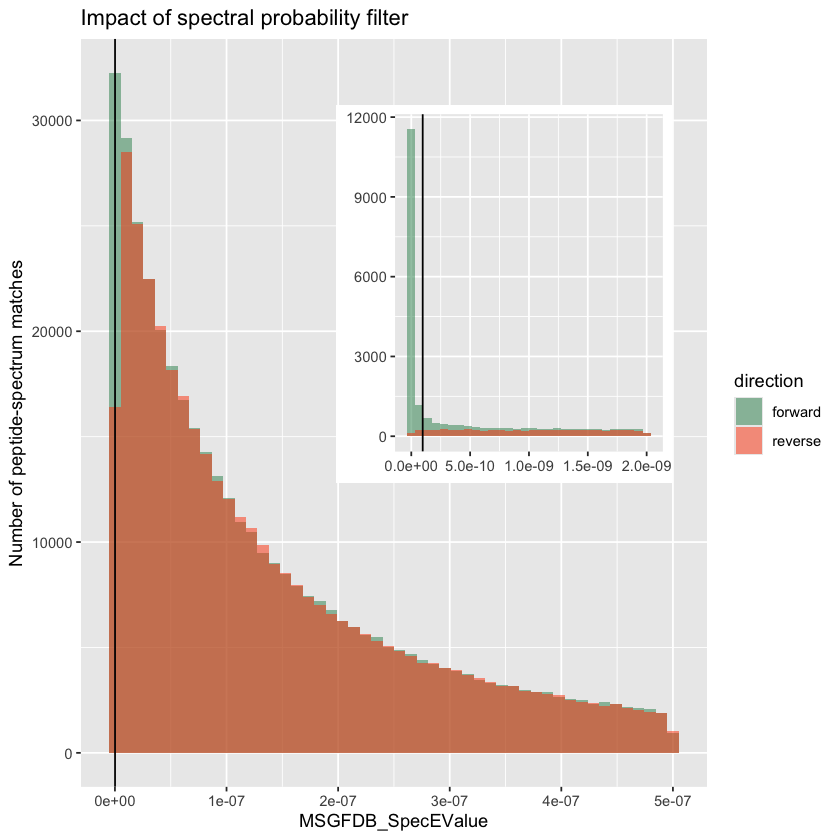

In [13]:
peps_for_plot <- bind_rows(forward_peptides, reversed_peptides, .id = "direction") %>%
  mutate(direction = case_when(direction == 1 ~ "forward", direction == 2 ~ "reverse"),
         direction = factor(direction))

main_plot <- ggplot(peps_for_plot) +
  geom_histogram(aes(x = MSGFDB_SpecEValue, fill = direction), bins = 50, alpha = 0.5, position = "identity") + 
  geom_vline(xintercept = 10 ^ optimized_filter) +
  scale_fill_manual(values = c("forward" = "seagreen", "reverse" = "orangered")) +
  ylab("Number of peptide-spectrum matches") +
  ggtitle("Impact of spectral probability filter")

zoom_plot <- peps_for_plot %>%
  # subset data - zoom in 
  filter(MSGFDB_SpecEValue < 2e-9) %>%
  ggplot() +
    geom_histogram(aes(x = MSGFDB_SpecEValue, fill = direction), bins = 30, alpha = 0.5, position = "identity") + 
    geom_vline(xintercept = 10 ^ optimized_filter) +
    scale_fill_manual(values = c("forward" = "seagreen", "reverse" = "orangered")) +
    theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank())
    
vp <- viewport(width = 0.4, height = 0.45, x = 0.6, y = 0.65)

main_plot
print(zoom_plot, vp = vp)

The main plot above is a histogram of forward and reverse peptides across all spectral probability values. 

The inset within this plot depicts a subset of the smallest spectral probabililty values (the same information as the main plot, zoomed in). The red bar to the left of the dashed line represents the estimated number of false identifications that will be included in this analysis. 

Apply the filter to the dataset and recalculate peptide and spectral FDR.

In [14]:
forward_peptides <- filter(forward_peptides, MSGFDB_SpecEValue < 10 ^ optimized_filter)

reversed_peptides <- filter(reversed_peptides, MSGFDB_SpecEValue < 10 ^ optimized_filter)

# Calculate spectral FDR
f_spec <- length(unique(forward_peptides$SpecID))
r_spec <- length(unique(reversed_peptides$SpecID))

fdr_spec <- ifelse(f_spec == 0 & r_spec == 0,
                   1,
                   (2 * r_spec) / (f_spec + r_spec))

# Calculate peptide FDR
f_pep <- length(unique(forward_peptides$Peptide_Sequence_with_Mods))
r_pep <- length(unique(reversed_peptides$Peptide_Sequence_with_Mods))

fdr_pep <- ifelse(f_pep == 0 & r_pep == 0,
                  1,
                  r_pep / (f_pep + r_pep))

paste("Spectral FDR:", fdr_spec)
paste("Peptide FDR:", fdr_pep)


[1] "Spectral FDR: 0.0499265785609398"

[1] "Peptide FDR: 0.0557613931085587"

## 3) Collapse to unique peptides and normalize their relative abundance

At this point in analysis the data has been filtered to only high probability peptide identifications, but more than one scan within a dataset can have the same peptide identification. This can be due to the peptide eluting into the mass spectrometer over the course of multiple scans or a peptide eluting as multiple charge states. 

Sum the relative abundance for peptide sequences detected more than once in a dataset, leaving a total relative abundance value for each peptide in each dataset.

In [15]:
forward_peptides <- forward_peptides %>%
  select(-c(SpecID, MSGFDB_SpecEValue)) %>%
  group_by(processed_dobj_id, Peptide_Sequence_with_Mods) %>%
  mutate(StatMomentsArea = sum(StatMomentsArea)) %>% 
  ungroup() %>%
  distinct(processed_dobj_id, Peptide_Sequence_with_Mods, StatMomentsArea)

head(forward_peptides)

processed_dobj_id,Peptide_Sequence_with_Mods,StatMomentsArea
<chr>,<chr>,<dbl>
nmdc:dobj-11-2k6s1505,VYLGAETTR,323402000
nmdc:dobj-11-2k6s1505,DTLPHTVTSGTGPTDPNSAK,52891000
nmdc:dobj-11-2k6s1505,SQVSEGSSLADGVK,1259380000
nmdc:dobj-11-2k6s1505,TLSDYNIQK,250540000
nmdc:dobj-11-2k6s1505,SALQNAASIAK,155670000
nmdc:dobj-11-2k6s1505,IETGELAGYK,43413000


Visualize the untransformed and un-normalized relative abundances.

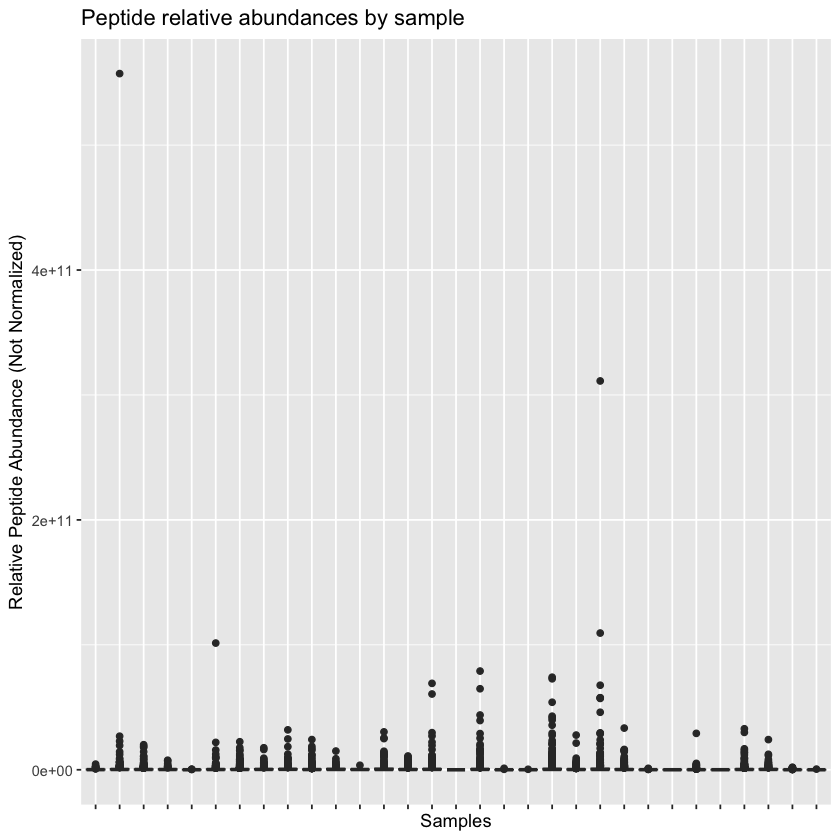

In [16]:
ggplot(forward_peptides) +
  geom_boxplot(aes(x = processed_dobj_id, y = StatMomentsArea)) +
  labs(x = "Samples", y = "Relative Peptide Abundance (Not Normalized)", title = "Peptide relative abundances by sample") +
  theme(axis.text.x = element_blank())

Apply log2 transformation and median normalize peptide abundances.

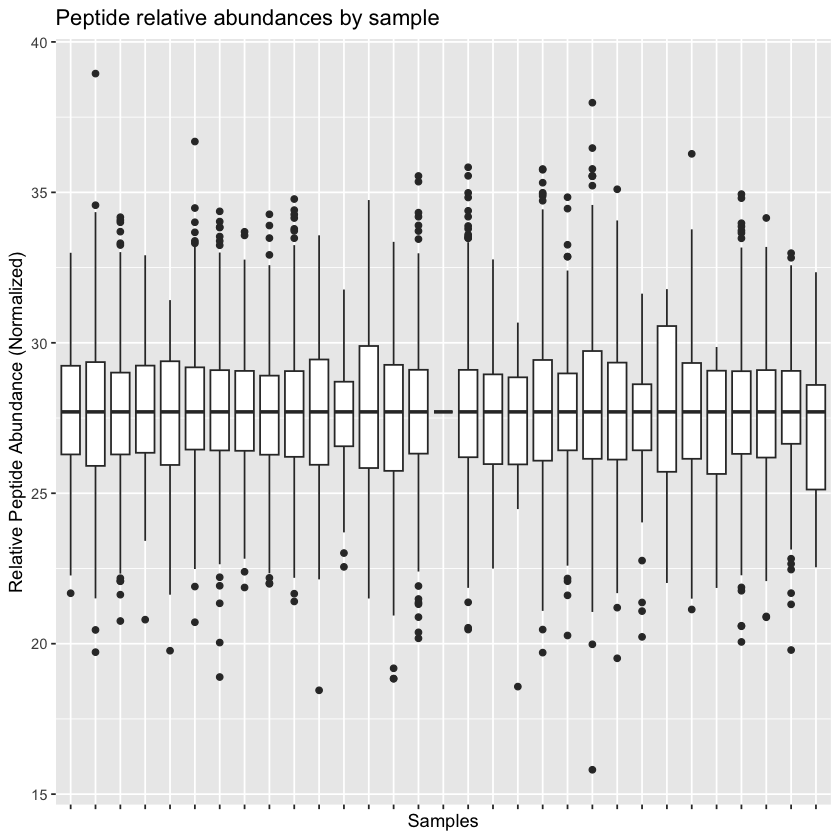

In [17]:
forward_peptides <- forward_peptides %>%
  mutate(StatMomentsAreaLog2 = log2(StatMomentsArea)) %>%
  group_by(processed_dobj_id) %>%
  mutate(group_medians = median(StatMomentsAreaLog2)) %>%
  ungroup() %>%
  distinct()

# Calculate data wide median
all_data_median <- median(forward_peptides$StatMomentsAreaLog2)

forward_peptides <- forward_peptides %>%
  # Subtract the sample wise median from each value within its group,
  # then add back in the data wide median to avoid negative abundances
  mutate(StatMomentsAreaLogNorm = StatMomentsAreaLog2 - group_medians + all_data_median)

ggplot(forward_peptides) +
  geom_boxplot(aes(x = processed_dobj_id, y = StatMomentsAreaLogNorm)) +
  labs(x = "Samples", y = "Relative Peptide Abundance (Normalized)", title = "Peptide relative abundances by sample") +
  theme(axis.text.x = element_blank())

## 4) Extract functional gene annotations for proteins

Collect peptide to protein mapping information for the passing peptide sequences.

In [18]:
peptide_protein_mapping <- unfiltered_results %>%
  filter(Peptide_Sequence_with_Mods %in% forward_peptides$Peptide_Sequence_with_Mods) %>%
  distinct(Peptide_Sequence_with_Mods, Protein)

head(peptide_protein_mapping)

Peptide_Sequence_with_Mods,Protein
<chr>,<chr>
NADSTLHTVTSGTAEGGESGTVFDSSYMAAGK,nmdc:wfmgan-11-a71gkg84.1_003113_596_1117
ETNPTLADIEQDSKVKDAIEK,nmdc:wfmgan-11-a71gkg84.1_046034_35_346
GETYVNVHTEKNPNGEIR,nmdc:wfmgan-11-a71gkg84.1_000318_745_1245
VANAQQAGAYGSGTALFGK,nmdc:wfmgan-11-a71gkg84.1_106431_2_277
VLKETNPTLADIEQDSK,nmdc:wfmgan-11-a71gkg84.1_046034_35_346
IFDISNPAAPVQLVDFR,nmdc:wfmgan-11-a71gkg84.1_073131_3_293


Annotation information for these proteins can be found in `Functional Annotation GFF` files.

Since the `data_objects` dataframe contains all objects associated with our study id, it also contains the relevant `Functional Annotation GFF` files. Subset this dataframe to GFF files associated with the 33 biosample ids that have a proteomic output in `proteomic_output_df`.

In [19]:
workflow_inputs <- (version_output %>% 
  select(-c('has_output','version')) %>% 
  unnest(has_input))$has_input

annotation_input_df <- data_objects %>%
  filter(data_object_type == "Functional Annotation GFF") %>%
  filter(biosample_id %in% proteomic_output_df$biosample_id) %>%
  filter(id %in% workflow_inputs) %>% 
  distinct(biosample_id, id, data_object_type, url)

head(annotation_input_df)

biosample_id,id,data_object_type,url
<chr>,<chr>,<chr>,<chr>
nmdc:bsm-13-0jw5n594,nmdc:dobj-11-fdngms90,Functional Annotation GFF,https://data.microbiomedata.org/data/nmdc:omprc-13-e4rebn56/nmdc:wfmgan-11-bnzfrb88.1/nmdc_wfmgan-11-bnzfrb88.1_functional_annotation.gff
nmdc:bsm-13-13145k83,nmdc:dobj-11-xxffzc65,Functional Annotation GFF,https://data.microbiomedata.org/data/nmdc:omprc-13-zd99ps92/nmdc:wfmgan-11-dvvh0237.1/nmdc_wfmgan-11-dvvh0237.1_functional_annotation.gff
nmdc:bsm-13-1p0tct86,nmdc:dobj-11-c24s6186,Functional Annotation GFF,https://data.microbiomedata.org/data/nmdc:omprc-13-eyz5jj82/nmdc:wfmgan-11-ewrwts75.1/nmdc_wfmgan-11-ewrwts75.1_functional_annotation.gff
nmdc:bsm-13-2fw5j754,nmdc:dobj-11-p55wx268,Functional Annotation GFF,https://data.microbiomedata.org/data/nmdc:omprc-13-f4jg2r75/nmdc:wfmgan-11-vcrp9p47.1/nmdc_wfmgan-11-vcrp9p47.1_functional_annotation.gff
nmdc:bsm-13-2yga6857,nmdc:dobj-11-4kn1g186,Functional Annotation GFF,https://data.microbiomedata.org/data/nmdc:omprc-13-bj8pxh81/nmdc:wfmgan-11-bsjywy32.1/nmdc_wfmgan-11-bsjywy32.1_functional_annotation.gff
nmdc:bsm-13-3dt9xs73,nmdc:dobj-11-q0k52648,Functional Annotation GFF,https://data.microbiomedata.org/data/nmdc:omprc-13-bjx9vr97/nmdc:wfmgan-11-8zxjs882.1/nmdc_wfmgan-11-8zxjs882.1_functional_annotation.gff


Preview the `Functional Annotation GFF` files and determine a subset of gene annotation information that should be pulled from all 33 files.

In [20]:
paste("Reading from", annotation_input_df$url[2])

head(gff_extract_features(annotation_input_df$url[2]))

[1] "Reading from https://data.microbiomedata.org/data/nmdc:omprc-13-zd99ps92/nmdc:wfmgan-11-dvvh0237.1/nmdc_wfmgan-11-dvvh0237.1_functional_annotation.gff"

,ID,translation_table,partial,start_type,product,product_source,codon,used_search_mode,cog,smart,...,median_spacer_length,Parent,e-value,model,accession,model_start,model_end,regulatory_class,bound_moiety,ncRNA_class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,nmdc:wfmgan-11-dvvh0237.1_000001_2_526,11,3',ATG,hypothetical protein,Hypo-rule applied,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,nmdc:wfmgan-11-dvvh0237.1_000001_708_819,NA,NA,NA,tRNA_Pro_GGG,NA,CCC,Bacterial,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,nmdc:wfmgan-11-dvvh0237.1_000001_929_1336,11,NA,ATG,nitrogen fixation/metabolism regulation signal transduction histidine kinase,COG5000,NA,NA,COG5000,SM00670,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,nmdc:wfmgan-11-dvvh0237.1_000001_1623_3890,11,NA,ATG,YVTN family beta-propeller protein,TIGR02276,NA,NA,COG3391,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,nmdc:wfmgan-11-dvvh0237.1_000001_3913_4917,11,NA,TTG,hypothetical protein,Hypo-rule applied,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,nmdc:wfmgan-11-dvvh0237.1_000001_5119_5322,11,NA,ATG,hypothetical protein,Hypo-rule applied,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Extract information from all 33 annotation files (this takes a while to run) and merge with `peptide_protein_mapping` so there is a final table of peptide-protein-annotation mapping (`annotation_mapping`).

In [21]:
gene_mapping <- distinct(annotation_input_df, id, url)

gene_mapping <- iterate_file_extract(
  input_df = gene_mapping,
  identifier_col = "id",
  url_col = "url",
  extract_cols = c("ID", "product", "product_source"),
  filter_col = "ID",
  filter_values = unique(peptide_protein_mapping$Protein),
  file_type = "gff"
)

In [22]:
# Merge with protein mapping information
# Drop data object ID since mappings are not dataset specific
annotation_mapping <- inner_join(gene_mapping, peptide_protein_mapping, by = join_by(ID == Protein)) %>%
  dplyr::rename(Protein = "ID") %>%
  distinct(Peptide_Sequence_with_Mods, Protein, product, product_source)

head(annotation_mapping)

,Peptide_Sequence_with_Mods,Protein,product,product_source
,<chr>,<chr>,<chr>,<chr>
1,ALMGSNMQR,nmdc:wfmgan-11-bnzfrb88.1_000010_2256_6224,DNA-directed RNA polymerase subunit beta,KO:K03043
2,ENADAYSRGAYPDVLK,nmdc:wfmgan-11-bnzfrb88.1_000125_3919_4230,heme-degrading monooxygenase HmoA,COG2329
3,RGTWWDWAPAK,nmdc:wfmgan-11-bnzfrb88.1_000220_2203_3417,uncharacterized protein,KO:K09927
4,VQAVDGITR,nmdc:wfmgan-11-bnzfrb88.1_000315_2763_3002,DNA-binding Lrp family transcriptional regulator,COG1522
5,HLCIHGHFYQPSR,nmdc:wfmgan-11-bnzfrb88.1_000945_1894_2820,alpha-amylase/alpha-mannosidase (GH57 family),COG1449
6,TTLTAAITK,nmdc:wfmgan-11-bnzfrb88.1_001130_2_115,elongation factor Tu,KO:K02358


## 5) Generate annotation and protein mappings for peptides using "Razor" strategy

Identify the razor protein, which is a method of limiting the assignment of degenerate peptides (i.e., peptides that map to more than one forward protein) to a most likely matched protein. 'Razor' references the principle Occam's razor, also known as the law of parsimony.

The rules are as follows:
- If a peptide is unique to a protein, then that protein is the razor
- Else, if a peptide belongs to more than one protein, but one of those proteins has a unique peptide, then that protein is the razor
- Else, if a peptide belongs to more than one protein and one of those proteins has the maximal number of peptides, then that protein is the razor
- Else, if a peptide belongs to more than one protein and more than one of those proteins has the maximal number of peptides, then collapse the proteins and gene annotations into single strings
- Else, if a peptide belongs to more than one protein and more than one of those proteins has a unique peptide, then the peptide is removed from analysis because its mapping is inconclusive

Use `annotation_mapping` as the input to the function `get_razor_protein()` from `aggregation_functions.R`. This will return protein and gene annotation information for each peptide, according to the above rules. 

In [23]:
# Add counts for use in razor logic function
# annotation_mapping has already been through distinct() so pairs (rows) are unique
annotation_mapping <- annotation_mapping %>%

  # Count the number of proteins that each peptide maps to
  group_by(Peptide_Sequence_with_Mods) %>%
  mutate(prot_count = n()) %>%
  ungroup() %>%
  
  # Count the number of REDUNDANT and UNIQUE peptides that each protein maps to
  group_by(Protein) %>%
  mutate(redundant_pep_count = sum(prot_count > 1),
         unique_pep_count = sum(prot_count == 1)) %>%
  ungroup()

head(annotation_mapping)

Peptide_Sequence_with_Mods,Protein,product,product_source,prot_count,redundant_pep_count,unique_pep_count
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
ALMGSNMQR,nmdc:wfmgan-11-bnzfrb88.1_000010_2256_6224,DNA-directed RNA polymerase subunit beta,KO:K03043,40,1,0
ENADAYSRGAYPDVLK,nmdc:wfmgan-11-bnzfrb88.1_000125_3919_4230,heme-degrading monooxygenase HmoA,COG2329,28,1,0
RGTWWDWAPAK,nmdc:wfmgan-11-bnzfrb88.1_000220_2203_3417,uncharacterized protein,KO:K09927,21,1,0
VQAVDGITR,nmdc:wfmgan-11-bnzfrb88.1_000315_2763_3002,DNA-binding Lrp family transcriptional regulator,COG1522,57,1,0
HLCIHGHFYQPSR,nmdc:wfmgan-11-bnzfrb88.1_000945_1894_2820,alpha-amylase/alpha-mannosidase (GH57 family),COG1449,2,1,0
TTLTAAITK,nmdc:wfmgan-11-bnzfrb88.1_001130_2_115,elongation factor Tu,KO:K02358,267,1,0


In [24]:
# Get razor mappings (long format)
razor_mapping <- get_razor_protein(annotation_mapping)

# Roll up - concatenate razor protein results (one row per peptide)
razor_mapping <- razor_mapping %>%
  group_by(Peptide) %>%
  mutate(Razor_Protein  = paste(Razor_Protein, collapse = ", "),
         product        = paste(product, collapse = ", "),
         product_source = paste(product_source, collapse = ", ")) %>%
  ungroup() %>%
  distinct()

head(razor_mapping)

Peptide,Razor_Protein,product,product_source
<chr>,<chr>,<chr>,<chr>
ALMGSNMQR,"nmdc:wfmgan-11-bnzfrb88.1_000010_2256_6224, nmdc:wfmgan-11-bnzfrb88.1_004935_1_1599, nmdc:wfmgan-11-bnzfrb88.1_007587_2_1345, nmdc:wfmgan-11-bnzfrb88.1_011098_3_1145, nmdc:wfmgan-11-bnzfrb88.1_014886_1_999, nmdc:wfmgan-11-bnzfrb88.1_030872_1_690, nmdc:wfmgan-11-bnzfrb88.1_064905_1_465, nmdc:wfmgan-11-bnzfrb88.1_084903_3_404, nmdc:wfmgan-11-bnzfrb88.1_097058_3_377, nmdc:wfmgan-11-bnzfrb88.1_100146_1_372, nmdc:wfmgan-11-bnzfrb88.1_143300_3_314, nmdc:wfmgan-11-bnzfrb88.1_156082_3_305, nmdc:wfmgan-11-bnzfrb88.1_194561_3_281, nmdc:wfmgan-11-szz9bq42.1_003917_2_1735, nmdc:wfmgan-11-szz9bq42.1_006997_3_1376, nmdc:wfmgan-11-szz9bq42.1_024941_3_773, nmdc:wfmgan-11-szz9bq42.1_041418_3_602, nmdc:wfmgan-11-szz9bq42.1_052702_2_532, nmdc:wfmgan-11-szz9bq42.1_072943_2_448, nmdc:wfmgan-11-szz9bq42.1_079358_3_431, nmdc:wfmgan-11-szz9bq42.1_090214_3_404, nmdc:wfmgan-11-szz9bq42.1_097132_3_389, nmdc:wfmgan-11-szz9bq42.1_104415_2_373, nmdc:wfmgan-11-szz9bq42.1_108199_1_369, nmdc:wfmgan-11-szz9bq42.1_117068_2_355, nmdc:wfmgan-11-szz9bq42.1_160597_2_307, nmdc:wfmgan-11-e98mdq66.1_22903_3_296, nmdc:wfmgan-11-e98mdq66.1_46036_1_279, nmdc:wfmgan-11-yjeh0m30.1_001035_1_2730, nmdc:wfmgan-11-yjeh0m30.1_002389_3_2213, nmdc:wfmgan-11-yjeh0m30.1_005211_1_1599, nmdc:wfmgan-11-yjeh0m30.1_013639_2_1024, nmdc:wfmgan-11-yjeh0m30.1_019595_2_856, nmdc:wfmgan-11-yjeh0m30.1_033399_1_648, nmdc:wfmgan-11-yjeh0m30.1_040409_2_583, nmdc:wfmgan-11-yjeh0m30.1_090419_1_384, nmdc:wfmgan-11-yjeh0m30.1_091035_2_385, nmdc:wfmgan-11-yjeh0m30.1_094173_2_376, nmdc:wfmgan-11-yjeh0m30.1_156175_2_301, nmdc:wfmgan-11-yjeh0m30.1_168947_2_289","DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta, DNA-directed RNA polymerase subunit beta","KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043, KO:K03043"
ENADAYSRGAYPDVLK,nmdc:wfmgan-11-9mdyy902.1_000542_195_506,heme-degrading monooxygenase HmoA,COG2329
RGTWWDWAPAK,"nmdc:wfmgan-11-bnzfrb88.1_000220_2203_3417, nmdc:wfmgan-11-ewrwts75.1_0110

## 6) Perform protein rollup and summarize into a final aggregated table of relative protein abundance

Combine razor information with relative abundance values.

In [25]:
forward_peptides <- forward_peptides %>%
  right_join(razor_mapping, by = join_by(Peptide_Sequence_with_Mods == Peptide)) %>%
  distinct()

head(forward_peptides)

processed_dobj_id,Peptide_Sequence_with_Mods,StatMomentsArea,StatMomentsAreaLog2,group_medians,StatMomentsAreaLogNorm,Razor_Protein,product,product_source
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
nmdc:dobj-11-2k6s1505,VYLGAETTR,323402000,28.26875,26.78594,29.18732,"nmdc:wfmgan-11-a71gkg84.1_094425_166_282, nmdc:wfmgan-11-afrz5241.1_046285_72_317","photosystem I subunit VII, photosystem I subunit VII","KO:K02691, KO:K02691"
nmdc:dobj-11-2k6s1505,DTLPHTVTSGTGPTDPNSAK,52891000,25.65652,26.78594,26.57509,"nmdc:wfmgan-11-ewrwts75.1_001323_2787_3257, nmdc:wfmgan-11-ewrwts75.1_005119_1004_1810, nmdc:wfmgan-11-ewrwts75.1_009192_213_1403, nmdc:wfmgan-11-ewrwts75.1_019478_415_1116, nmdc:wfmgan-11-vcrp9p47.1_000448_1955_2434, nmdc:wfmgan-11-vcrp9p47.1_000463_36_842, nmdc:wfmgan-11-vcrp9p47.1_000531_2_1216, nmdc:wfmgan-11-vcrp9p47.1_008560_3_299, nmdc:wfmgan-11-8zxjs882.1_000386_1779_2495, nmdc:wfmgan-11-8zxjs882.1_000482_1879_2190, nmdc:wfmgan-11-8zxjs882.1_009381_1_510, nmdc:wfmgan-11-8zxjs882.1_029454_2_358, nmdc:wfmgan-11-awd7ke72.1_00183_134_940, nmdc:wfmgan-11-awd7ke72.1_00488_1024_1959, nmdc:wfmgan-11-awd7ke72.1_17875_2_196, nmdc:wfmgan-11-a71gkg84.1_000507_1580_2041, nmdc:wfmgan-11-a71gkg84.1_005396_2_430, nmdc:wfmgan-11-a71gkg84.1_104278_2_277, nmdc:wfmgan-11-9mdyy902.1_000322_3078_3443, nmdc:wfmgan-11-9mdyy902.1_002777_624_1232, nmdc:wfmgan-11-qb4s5g41.1_017412_316_1002, nmdc:wfmgan-11-b6sp3q07.1_001955_161_967, nmdc:wfmgan-11-b6sp3q07.1_004515_1424_1825, nmdc:wfmgan-11-b6sp3q07.1_004671_928_1584, nmdc:wfmgan-11-b6sp3q07.1_016631_2_535, nmdc:wfmgan-11-b6sp3q07.1_174030_2_295, nmdc:wfmgan-11-7j1ws791.1_000438_1906_2712, nmdc:wfmgan-11-7j1ws791.1_005543_105_1136, nmdc:wfmgan-11-7j1ws791.1_007059_1_312, nmdc:wfmgan-11-7j1ws791.1_025414_3_587, nmdc:wfmgan-11-7j1ws791.1_035592_2_505, nmdc:wfmgan-11-7j1ws791.1_069894_2_379, nmdc:wfmgan-11-yjeh0m30.1_000695_2938_3477, nmdc:wfmgan-11-yjeh0m30.1_002652_494_1570, nmdc:wfmgan-11-yjeh0m30.1_003114_1313_1996, nmdc:wfmgan-11-yjeh0m30.1_024470_1_642, nmdc:wfmgan-11-yjeh0m30.1_033010_271_651, nmdc:wfmgan-11-yjeh0m30.1_034616_189_635, nmdc:wfmgan-11-yjeh0m30.1_100025_1_366, nmdc:wfmgan-11-yjeh0m30.1_203262_2_277","plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, hypothetical protein, cytochrome c oxidase subunit II","COG3794, KO:K02275, COG3794, KO:K02275, KO:K02275, KO:K02275, COG3794, KO:K02275, KO:K02275, COG3794, COG3794, KO:K02275, KO:K02275, COG3794, KO:K02275, KO:K02275, COG3794, KO:K02275, COG3794, KO:K02275, KO:K02275, KO:K02275, KO:K02275, COG3794, COG3794, KO:K02275, KO:K02275, COG3794, COG3794, COG3794, KO:K02275, COG3794, KO:K02275, COG3794, COG3794, KO:K02275, COG3794, KO:K02275, Hypo-rule applied, KO:K02275"
nmdc:dobj-11-2k6s1505,SQVSEGSSLADGVK,1259380000,30.23007,26.78594,31.14864,nmdc:wfmgan-11-a71gkg84.1_103783_2_277,type IV pilus assembly protein PilA,KO:K02650
nmdc:dobj-11-2k6s1505,TLSDYNIQK,250540000,27.90047,26.78594,28.81904,nmdc:wfmgan-11-a71gkg84.1_104452_3_278,ubiquitin C,KO:K08770
nmdc:dobj-11-2k6s1505,SALQNAASIAK,155670000,27.21392,26.78594,28.13249,nmdc:wfmgan-11-p3dkkz54.1_018834_2_562,ch

De-log the peptide abundances, sum the abundances for each razor protein and log transform the rolled up protein abundances.

In [26]:
protein_abundances <- forward_peptides %>%

  # De-log transform the peptide abundances
  mutate(StatMomentsAreaNorm = 2 ^ StatMomentsAreaLogNorm) %>%

  # Sum peptide abundances for each protein
  group_by(processed_dobj_id, Razor_Protein) %>%
  mutate(StatMomentsAreaNormSum = sum(StatMomentsAreaNorm)) %>%
  ungroup() %>%

  # Log transform the rolled up protein abundances (final result - StatMomentsAreaLogNormSum)
  distinct(processed_dobj_id, product, product_source, Razor_Protein, StatMomentsAreaNormSum) %>%
  mutate(StatMomentsAreaLogNormSum = log2(StatMomentsAreaNormSum)) %>%
  select(-StatMomentsAreaNormSum)

head(protein_abundances)

processed_dobj_id,product,product_source,Razor_Protein,StatMomentsAreaLogNormSum
<chr>,<chr>,<chr>,<chr>,<dbl>
nmdc:dobj-11-2k6s1505,"photosystem I subunit VII, photosystem I subunit VII","KO:K02691, KO:K02691","nmdc:wfmgan-11-a71gkg84.1_094425_166_282, nmdc:wfmgan-11-afrz5241.1_046285_72_317",29.18732
nmdc:dobj-11-2k6s1505,"plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, plastocyanin, cytochrome c oxidase subunit II, plastocyanin, cytochrome c oxidase subunit II, hypothetical protein, cytochrome c oxidase subunit II","COG3794, KO:K02275, COG3794, KO:K02275, KO:K02275, KO:K02275, COG3794, KO:K02275, KO:K02275, COG3794, COG3794, KO:K02275, KO:K02275, COG3794, KO:K02275, KO:K02275, COG3794, KO:K02275, COG3794, KO:K02275, KO:K02275, KO:K02275, KO:K02275, COG3794, COG3794, KO:K02275, KO:K02275, COG3794, COG3794, COG3794, KO:K02275, COG3794, KO:K02275, COG3794, COG3794, KO:K02275, COG3794, KO:K02275, Hypo-rule applied, KO:K02275","nmdc:wfmgan-11-ewrwts75.1_001323_2787_3257, nmdc:wfmgan-11-ewrwts75.1_005119_1004_1810, nmdc:wfmgan-11-ewrwts75.1_009192_213_1403, nmdc:wfmgan-11-ewrwts75.1_019478_415_1116, nmdc:wfmgan-11-vcrp9p47.1_000448_1955_2434, nmdc:wfmgan-11-vcrp9p47.1_000463_36_842, nmdc:wfmgan-11-vcrp9p47.1_000531_2_1216, nmdc:wfmgan-11-vcrp9p47.1_008560_3_299, nmdc:wfmgan-11-8zxjs882.1_000386_1779_2495, nmdc:wfmgan-11-8zxjs882.1_000482_1879_2190, nmdc:wfmgan-11-8zxjs882.1_009381_1_510, nmdc:wfmgan-11-8zxjs882.1_029454_2_358, nmdc:wfmgan-11-awd7ke72.1_00183_134_940, nmdc:wfmgan-11-awd7ke72.1_00488_1024_1959, nmdc:wfmgan-11-awd7ke72.1_17875_2_196, nmdc:wfmgan-11-a71gkg84.1_000507_1580_2041, nmdc:wfmgan-11-a71gkg84.1_005396_2_430, nmdc:wfmgan-11-a71gkg84.1_104278_2_277, nmdc:wfmgan-11-9mdyy902.1_000322_3078_3443, nmdc:wfmgan-11-9mdyy902.1_002777_624_1232, nmdc:wfmgan-11-qb4s5g41.1_017412_316_1002, nmdc:wfmgan-11-b6sp3q07.1_001955_161_967, nmdc:wfmgan-11-b6sp3q07.1_004515_1424_1825, nmdc:wfmgan-11-b6sp3q07.1_004671_928_1584, nmdc:wfmgan-11-b6sp3q07.1_016631_2_535, nmdc:wfmgan-11-b6sp3q07.1_174030_2_295, nmdc:wfmgan-11-7j1ws791.1_000438_1906_2712, nmdc:wfmgan-11-7j1ws791.1_005543_105_1136, nmdc:wfmgan-11-7j1ws791.1_007059_1_312, nmdc:wfmgan-11-7j1ws791.1_025414_3_587, nmdc:wfmgan-11-7j1ws791.1_035592_2_505, nmdc:wfmgan-11-7j1ws791.1_069894_2_379, nmdc:wfmgan-11-yjeh0m30.1_000695_2938_3477, nmdc:wfmgan-11-yjeh0m30.1_002652_494_1570, nmdc:wfmgan-11-yjeh0m30.1_003114_1313_1996, nmdc:wfmgan-11-yjeh0m30.1_024470_1_642, nmdc:wfmgan-11-yjeh0m30.1_033010_271_651, nmdc:wfmgan-11-yjeh0m30.1_034616_189_635, nmdc:wfmgan-11-yjeh0m30.1_100025_1_366, nmdc:wfmgan-11-yjeh0m30.1_203262_2_277",26.57509
nmdc:dobj-11-2k6s1505,type IV pilus assembly protein PilA,KO:K02650,nmdc:wfmgan-11-a71gkg84.1_103783_2_277,31.14864
nmdc:dobj-11-2k6s1505,ubiquitin C,KO:K08770,nmdc:wfmgan-11-a71gkg84.1_104452_3_278,28.81904
nmdc:dobj-11-2k6s1505,chaperonin GroEL,KO:K04077,nmdc:wfmgan-11-p3dkkz54.1_018834_2_562,28.13249
nmdc:dobj-11-2k6s1505,hypothetical protein,Hypo-rule applied,nmdc:wfmgan-11-b6sp3q07.1_053672_1_546,26.29020


## Final aggregated table of relative protein abundance

Reformat these results into a proteomic table, where each row indicates a protein and each column indicates a sample/dataset. The values within are log transformed, median normalized relative abundance values. This table or the longform version above can be used in further proteomic analyses.

In [27]:
aggregated_proteomic_output <- protein_abundances %>%
  select(processed_dobj_id, Razor_Protein, StatMomentsAreaLogNormSum) %>%
  pivot_wider(names_from = "processed_dobj_id", values_from = "StatMomentsAreaLogNormSum")

head(aggregated_proteomic_output)

Razor_Protein,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2szyc560,nmdc:dobj-11-301yh759,nmdc:dobj-11-3378mg86,nmdc:dobj-11-3ak2bc31,nmdc:dobj-11-4bwzhs42,nmdc:dobj-11-7psagy79,nmdc:dobj-11-7r5yea49,nmdc:dobj-11-7x21d450,...,nmdc:dobj-11-tk9hc081,nmdc:dobj-11-vjmd5h28,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-xm1yjv87,nmdc:dobj-11-y2aefn18,nmdc:dobj-11-yrbs4v96,nmdc:dobj-11-z47wnf07,nmdc:dobj-11-z8hc0j30,nmdc:dobj-11-zhz66007,nmdc:dobj-11-zn9eyg46
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"nmdc:wfmgan-11-a71gkg84.1_094425_166_282, nmdc:wfmgan-11-afrz5241.1_046285_72_317",29.18732,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
"nmdc:wfmgan-11-ewrwts75.1_001323_2787_3257, nmdc:wfmgan-11-ewrwts75.1_005119_1004_1810, nmdc:wfmgan-11-ewrwts75.1_009192_213_1403, nmdc:wfmgan-11-ewrwts75.1_019478_415_1116, nmdc:wfmgan-11-vcrp9p47.1_000448_1955_2434, nmdc:wfmgan-11-vcrp9p47.1_000463_36_842, nmdc:wfmgan-11-vcrp9p47.1_000531_2_1216, nmdc:wfmgan-11-vcrp9p47.1_008560_3_299, nmdc:wfmgan-11-8zxjs882.1_000386_1779_2495, nmdc:wfmgan-11-8zxjs882.1_000482_1879_2190, nmdc:wfmgan-11-8zxjs882.1_009381_1_510, nmdc:wfmgan-11-8zxjs882.1_029454_2_358, nmdc:wfmgan-11-awd7ke72.1_00183_134_940, nmdc:wfmgan-11-awd7ke72.1_00488_1024_1959, nmdc:wfmgan-11-awd7ke72.1_17875_2_196, nmdc:wfmgan-11-a71gkg84.1_000507_1580_2041, nmdc:wfmgan-11-a71gkg84.1_005396_2_430, nmdc:wfmgan-11-a71gkg84.1_104278_2_277, nmdc:wfmgan-11-9mdyy902.1_000322_3078_3443, nmdc:wfmgan-11-9mdyy902.1_002777_624_1232, nmdc:wfmgan-11-qb4s5g41.1_017412_316_1002, nmdc:wfmgan-11-b6sp3q07.1_001955_161_967, nmdc:wfmgan-11-b6sp3q07.1_004515_1424_1825, nmdc:wfmgan-11-b6sp3q07.1_004671_928_1584, nmdc:wfmgan-11-b6sp3q07.1_016631_2_535, nmdc:wfmgan-11-b6sp3q07.1_174030_2_295, nmdc:wfmgan-11-7j1ws791.1_000438_1906_2712, nmdc:wfmgan-11-7j1ws791.1_005543_105_1136, nmdc:wfmgan-11-7j1ws791.1_007059_1_312, nmdc:wfmgan-11-7j1ws791.1_025414_3_587, nmdc:wfmgan-11-7j1ws791.1_035592_2_505, nmdc:wfmgan-11-7j1ws791.1_069894_2_379, nmdc:wfmgan-11-yjeh0m30.1_000695_2938_3477, nmdc:wfmgan-11-yjeh0m30.1_002652_494_1570, nmdc:wfmgan-11-yjeh0m30.1_003114_1313_1996, nmdc:wfmgan-11-yjeh0m30.1_024470_1_642, nmdc:wfmgan-11-yjeh0m30.1_033010_271_651, nmdc:wfmgan-11-yjeh0m30.1_034616_189_635, nmdc:wfmgan-11-yjeh0m30.1_100025_1_366, nmdc:wfmgan-11-yjeh0m30.1_203262_2_277",26.57509,NA,27.57740,NA,NA,27.88671,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,27.01618,26.88819,NA,NA
nmdc:wfmgan-11-a71gkg84.1_103783_2_277,31.14864,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
nmdc:wfmgan-11-a71gkg84.1_104452_3_278,28.81904,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
nmdc:wfmgan-11-p3dkkz54.1_018834_2_562,28.13249,NA,29.01038,NA,30.0706,NA,28.55662,NA,NA,...,NA,NA,28.79139,NA,31.35701,NA,NA,NA,NA,NA
nmdc:wfmgan-11-b6sp3q07.1_053672_1_546,26.29020,NA,NA,NA,NA,NA,29.51453,NA,NA,...,NA,NA,NA,NA,NA,NA,28.65492,NA,NA,NA


The generated protein table can be used as input to the software [pmartR](https://shinyproxy.emsl.pnnl.gov/app/pmart), which performs statistical analyses such as ANOVA and independence of missing data (IMD) tests. In this case, the aggregated proteomics table (`aggregated_proteomic_output`) would be equivalent to pmartR's `e_data` and the peptide to protein to gene mappings (`razor_mapping`) would be equivalent to pmartR's `e_meta`.

<img src="../pmartR_logo_final.jpg" width="25%"/>

pmartR requires sample metadata to parameterize analyses and interpret the data. For this example dataset, an API call will capture the biosample metadata (`biosample_metadata`) that would be equivalent to pmartR's `f_data`.

Gather biosample metadata via the NMDC API `collection` endpoint, using the function `get_results_by_id()` in `utility_functions.R` and searching for the `biosample_id`s associated with each output in `proteomic_output_df`.

In [28]:
biosample_metadata <- get_results_by_id(collection = "biosample_set",
                                        match_id_field = "id", 
                                        id_list = proteomic_output_df$biosample_id, 
                                        fields = "id,depth.has_numeric_value") %>%
  # Cleanup json output
  unnest(depth) %>%
  dplyr::rename(biosample_id = id,
                depth_m = has_numeric_value) %>%
  # Add data object IDs to connect biosample metadata to processed results
  left_join(select(proteomic_output_df, processed_dobj_id, biosample_id), by = join_by("biosample_id"))

head(biosample_metadata)

biosample_id,depth_m,processed_dobj_id
<chr>,<dbl>,<chr>
nmdc:bsm-13-0jw5n594,0.0,nmdc:dobj-11-pxnhdj84
nmdc:bsm-13-13145k83,0.2,nmdc:dobj-11-xm1yjv87
nmdc:bsm-13-1p0tct86,0.2,nmdc:dobj-11-bxyvx506
nmdc:bsm-13-2fw5j754,0.4,nmdc:dobj-11-z8hc0j30
nmdc:bsm-13-2yga6857,0.1,nmdc:dobj-11-y2aefn18
nmdc:bsm-13-3dt9xs73,0.5,nmdc:dobj-11-c85nc786
